In [1]:
from pathlib import Path
import os
import pandas as pd
import re
import numpy as np

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

In [3]:
from transformers import BertTokenizerFast, BertModel, AdamW, get_linear_schedule_with_warmup

In [4]:
from project_path import project_path
project_path(1)

d:\Users\Nicholas\Projects\NLP\fake_news


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc, precision_recall_fscore_support

In [6]:
# import from src
import src.models.models as models
import src.models.data_loader as data_loader
import src.models.training as training

In [7]:
import pickle

In [8]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
# seeds
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [10]:
# if gpu is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [11]:
# data directories
proj_dir = Path.cwd().parents[0]
data_raw = Path(proj_dir, 'data', 'raw')

In [12]:
data_fake = pd.read_csv(Path(data_raw, 'Fake.csv'))
data_true = pd.read_csv(Path(data_raw, 'True.csv'))

In [13]:
data_fake['target'] = 1
data_true['target'] = 0

In [39]:
data = pd.concat([data_fake, data_true])

In [47]:
data['text'].str.len().describe()

count    44898.000000
mean      2469.109693
std       2171.617091
min          1.000000
25%       1234.000000
50%       2186.000000
75%       3105.000000
max      51794.000000
Name: text, dtype: float64

<AxesSubplot:>

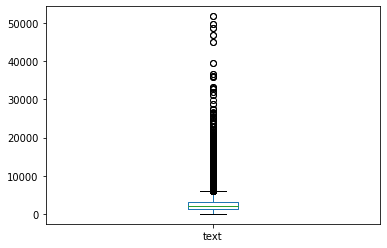

In [46]:
data['text'].str.len().plot.box()

In [ ]:
# take data with long strings only
data = data.loc[data.text.str.len() > 1024, :]

In [14]:
# Subsample
data_sample, _ = train_test_split(data, train_size=0.1, random_state=RANDOM_SEED, shuffle=True, stratify=data['target'])
data_sample = data_sample.rename(columns = {'text':'content'})

#### Train test split

In [15]:
df_train, df_test = train_test_split(
    data_sample, 
    train_size=0.8, 
    random_state=RANDOM_SEED, 
    shuffle=True,
    stratify=data_sample['target'])

In [16]:
df_val, df_test = train_test_split(
    df_test, 
    train_size=0.5, 
    random_state=RANDOM_SEED, 
    shuffle=True, 
    stratify=df_test['target'])

In [17]:
print(df_train.shape, df_val.shape, df_test.shape)

(3591, 5) (449, 5) (449, 5)


In [18]:
print(df_train.target.value_counts(normalize = True))

1    0.522974
0    0.477026
Name: target, dtype: float64


#### Train model

In [19]:
PRE_TRAINED_MODEL_NAME = "D:/Users/Nicholas/Projects/BERT_pretrained/biobert-base-cased-v1.1"
tokenizer = BertTokenizerFast.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [20]:
max_len = 512 * 4
batch_size = 32

In [21]:
train_data_loader = data_loader.create_data_loader(
    df = df_train, 
    tokenizer = tokenizer, 
    max_len = max_len, 
    batch_size = batch_size, 
    chunksize = 512, 
    sampler = None, 
    shuffle = True, 
    drop_last = True)

val_data_loader = data_loader.create_data_loader(
    df = df_val, 
    tokenizer = tokenizer, 
    max_len = max_len, 
    batch_size = batch_size, 
    chunksize = 512, 
    sampler = None, 
    shuffle = False, 
    drop_last = False)

test_data_loader = data_loader.create_data_loader(
    df = df_test, 
    tokenizer = tokenizer, 
    max_len = max_len, 
    batch_size = batch_size, 
    chunksize = 512, 
    sampler = None, 
    shuffle = False, 
    drop_last = False)

In [22]:
params_dict = {
    'PRE_TRAINED_MODEL_NAME':PRE_TRAINED_MODEL_NAME, 
    'n_classes':2, 
    'add_linear':[512,256], 
    'attn_bias':False, 
    'freeze_layer_count':8
}

In [23]:
model = models.HIBERT(**params_dict)

Some weights of the model checkpoint at D:/Users/Nicholas/Projects/BERT_pretrained/biobert-base-cased-v1.1 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

bert.embeddings.word_embeddings.weight False
bert.embeddings.position_embeddings.weight False
bert.embeddings.token_type_embeddings.weight False
bert.embeddings.LayerNorm.weight False
bert.embeddings.LayerNorm.bias False
bert.encoder.layer.0.attention.self.query.weight False
bert.encoder.layer.0.attention.self.query.bias False
bert.encoder.layer.0.attention.self.key.weight False
bert.encoder.layer.0.attention.self.key.bias False
bert.encoder.layer.0.attention.self.value.weight False
bert.encoder.layer.0.attention.self.value.bias False
bert.encoder.layer.0.attention.output.dense.weight False
bert.encoder.layer.0.attention.output.dense.bias False
bert.encoder.layer.0.attention.output.LayerNorm.weight False
bert.encoder.layer.0.attention.output.LayerNorm.bias False
bert.encoder.layer.0.intermediate.dense.weight False
bert.encoder.layer.0.intermediate.dense.bias False
bert.encoder.layer.0.output.dense.weight False
bert.encoder.layer.0.output.dense.bias False
bert.encoder.layer.0.output.Lay

In [25]:
epochs = 2
optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)

total_steps = len(train_data_loader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [26]:
%%time
history = training.train_model(epochs, model, train_data_loader, val_data_loader, loss_fn, optimizer, device, scheduler)

In [27]:
pickle.dump(history, open('training_history.pkl', 'wb'))

NameError: name 'history' is not defined

#### plot history

In [28]:
history = pickle.load(open('training_history.pkl', 'rb'))

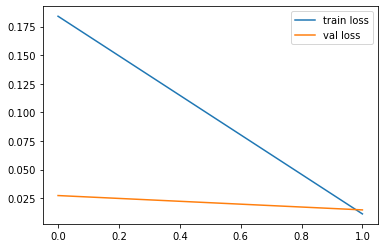

In [29]:
plt.plot(list(range(epochs)), history['train_loss'], label = 'train loss')
plt.plot(list(range(epochs)), history['val_loss'], label = 'val loss')
plt.legend()

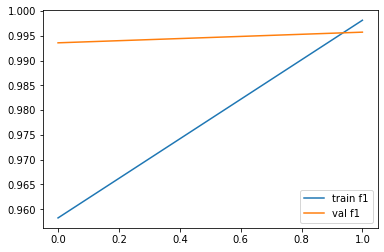

In [30]:
plt.plot(list(range(epochs)), history['train_f1'], label = 'train f1')
plt.plot(list(range(epochs)), history['val_f1'], label = 'val f1')
plt.legend()

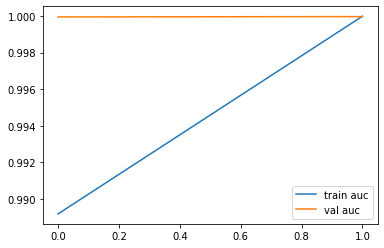

In [31]:
plt.plot(list(range(epochs)), history['train_auc'], label = 'train auc')
plt.plot(list(range(epochs)), history['val_auc'], label = 'val auc')
plt.legend()

#### make predictions

In [32]:
model_trained = models.HIBERT(**params_dict)
model_trained.load_state_dict(torch.load('best_model_state.bin'))

best_threshold = pickle.load(open('best_threshold.pkl', 'rb'))

Some weights of the model checkpoint at D:/Users/Nicholas/Projects/BERT_pretrained/biobert-base-cased-v1.1 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
%%time

predictions = training.pred_model(
    model = model_trained, 
    data_loader = test_data_loader, 
    device = device, 
    best_threshold = best_threshold)

Wall time: 7min 43s


In [35]:
predictions_df = pd.DataFrame(predictions)

In [36]:
predictions_df

,target,pred_proba,pred,attn_wts,input_ids
0,1,0.997227,1,"[[0.0029407204, 0.0023947693, 0.0024854934, 0....","[[101, 1274, 18728, 189, 27321, 188, 9802, 110..."
1,1,0.986989,1,"[[0.0018907926, 0.0015858073, 0.0020402663, 0....","[[101, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
2,0,0.003147,0,"[[0.0013623307, 0.0014797682, 0.0014003646, 0....","[[101, 16358, 2728, 7535, 7535, 120, 12724, 88..."
3,1,0.997423,1,"[[0.002616192, 0.001778652, 0.0015957888, 0.00...","[[101, 1274, 18728, 189, 27321, 188, 2848, 118..."
4,1,0.997179,1,"[[0.00084205775, 0.0008064795, 0.00081112405, ...","[[101, 1274, 18728, 189, 27321, 3711, 1103, 17..."
...,...,...,...,...,...
444,0,0.003076,0,"[[0.0020473346, 0.0022166132, 0.0023637896, 0....","[[101, 13445, 1633, 113, 1231, 27603, 114, 118..."
445,0,0.003250,0,"[[0.0020672684, 0.0022434471, 0.0021407828, 0....","[[101, 21718, 14964, 19308, 113, 1231, 27603, ..."
446,1,0.997322,1,"[[0.0011641239, 0.000672378, 0.00064630806, 0....","[[101, 22679, 1644, 11877, 4819, 184, 2822, 19..."
447,0,0.003316,0,"[[0.0020847928, 0.002004447, 0.0021280136, 0.0...","[[101, 3821, 1324, 14810, 113, 1231, 27603, 11..."
